## Example - Usage of regularization and depolarizing noise mitigation options of quantum kernels

This notebook demonstrates the use of the regularization option for both FQK and PQK and shows how to use depolarizing noise mitigation options, which is only meaningful for fidelity quantum kernels. The regularization and mitigation methods are based on the theory outlined in http://arxiv.org/pdf/2105.02276v1

In [3]:
# necessary python and sQUlearn imports
import numpy as np
import matplotlib.pyplot as plt

from squlearn.feature_map import QEKFeatureMap
from squlearn.kernel import FidelityKernel, ProjectedQuantumKernel
from squlearn.kernel import QKRR
from squlearn.util import Executor

##### Simple artificial data generation

In [2]:
# generate some training and test data
x = np.linspace(-0.8, 0.8, 20)
x_fine = np.linspace(-0.9, 0.9, 200)
y = np.sin(10.0 * x) * np.cos(np.exp(2 * x))

##### Define the QEK feature map

In [12]:
num_qubits = 10
fmap = QEKFeatureMap(num_qubits, num_features=1, num_layers=2)

##### Define the Executor()

Since the effect of regularization as well as depolarizing noise mitigation techniques can only be demonstrated in the presence of noise, we perform qasm simulations in the following

In [4]:
# Define the executor and set the desired number of shots
executor = Executor("qasm_simulator")
executor.set_shots(1000)

##### Demonstrating regularization options in QKRR with FQK (takes about 30s)

In [17]:
# Define the FQK
qkernel = FidelityKernel(fmap, executor=executor, parameter_seed=0, regularization="thresholding")
# the alternative option would be 'tikhonov'

# alternatively for PQK
# pqk_kernel = ProjectedQuantumKernel(fmap, executor=executor, regularization="thresholding")

# Set the QKRR instance and with
qkrr_inst = QKRR(quantum_kernel=qkernel, alpha=1e-1)
qkrr_inst.fit(x.reshape(-1,1), y)
y_pred = qkrr_inst.predict(x_fine.reshape(-1, 1))

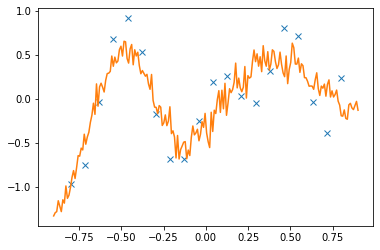

In [21]:
# Plot the results
plt.plot(x, y, "x")
plt.plot(x_fine, y_pred)

##### Demonstrating depolarizing noise mitigation for fidelity quantum kernels

In [7]:
# Set the FQK with the option of mit_depol_noise
# Since we are using only a qasm_simulator this option is in principal useless,
# however, in this case we demonstrate the availability of this option and it's main effect,
# i.e. restoring ones on the diagonal
kernel_mit = FidelityKernel(
    fmap, executor=executor, mit_depol_noise="msplit", parameter_seed=10
)  # the alternative option would be 'mmean'
kernel_mit.evaluate(x.reshape(-1, 1))

array([[ 1.00000000e+00,  9.73189442e-01,  9.03577691e-01,
         8.06578161e-01,  6.95517490e-01,  5.47373472e-01,
         4.42834309e-01,  3.61635503e-01,  2.52114649e-01,
         1.77982964e-01,  1.34767434e-01,  7.58603868e-02,
         6.11149738e-02,  4.61617296e-02,  2.11142628e-02,
         3.67340880e-03,  2.11983209e-03, -4.08943582e-04,
        -1.68596772e-03,  1.54095207e-03],
       [ 9.73189442e-01,  1.00000000e+00,  9.63710369e-01,
         8.88917490e-01,  7.99801847e-01,  6.84486967e-01,
         5.62516578e-01,  4.75713515e-01,  3.64816516e-01,
         2.62097092e-01,  1.95894998e-01,  1.22783561e-01,
         9.63935673e-02,  5.10249951e-02,  3.25544003e-02,
         1.95361005e-02,  8.93354692e-03,  1.35737214e-02,
         4.90670495e-03, -1.38641994e-03],
       [ 9.03577691e-01,  9.63710369e-01,  1.00000000e+00,
         9.63245871e-01,  8.94180344e-01,  8.12764073e-01,
         6.90634942e-01,  5.80878264e-01,  4.59249489e-01,
         3.70342253e-01,  2.7

In [8]:
# Compare to the kernel without this option (subtracting identiy necessary due to inherent regularization of QKRR)
print(qkrr_inst.k_train - 1e-1 * np.eye(np.shape(qkrr_inst.k_train)[0]))

[[ 1.00608320e+00  9.60552673e-01  9.08232124e-01  8.23261922e-01
   6.95005660e-01  5.80918064e-01  4.22569957e-01  3.63654124e-01
   2.49457191e-01  1.84207765e-01  1.29252625e-01  8.29574232e-02
   5.20052795e-02  4.06506615e-02  1.88380681e-02  1.68131723e-02
   9.20524224e-04  2.05447330e-03  1.41934389e-03  4.81922752e-04]
 [ 9.60552673e-01  1.01150726e+00  9.65017765e-01  9.12780885e-01
   8.12357950e-01  7.15401169e-01  5.74036736e-01  4.71066846e-01
   3.66221041e-01  2.64765059e-01  2.10571736e-01  1.16506673e-01
   9.38368976e-02  6.71235251e-02  3.89243076e-02  2.12346095e-02
   1.00260897e-02  3.49492403e-03 -6.85985958e-04  6.05155211e-06]
 [ 9.08232124e-01  9.65017765e-01  1.01614022e+00  9.78864226e-01
   9.19387865e-01  8.23139312e-01  6.98175175e-01  5.92450975e-01
   4.54689384e-01  3.81032872e-01  2.88366422e-01  1.87717450e-01
   1.24854213e-01  1.06844687e-01  5.78595977e-02  4.38030458e-02
   2.63606295e-02  1.46388061e-02  4.63455406e-03  3.63505137e-03]
 [ 8.23